## Analyses of Maize drought gene expression data
#### This notebook contains code on filtering the maize drought expression dataframe, PyCombat based batch effect correction, dimensionality reduction, surveying expression if individual genes, and machine learning. 

In [1]:
#import packages
import pandas as pd
import seaborn as sns
import numpy as np
import re
import json
import csv
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster import hierarchy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
plt.rcParams['pdf.fonttype'] = 42
from combat.pycombat import pycombat

In [2]:
df = pd.read_csv('maize_TPM.tsv', sep='\t')
expr_df = df.set_index(df.columns[0])

In [3]:
expr_df.head()

,ERR3212267,ERR3212268,ERR3212269,ERR3212270,ERR3212271,ERR3212272,ERR3212273,ERR3212274,ERR3212275,ERR3212276,...,SRR342069,SRR342063,SRR342061,SRR2144431,SRR342060,SRR342064,SRR342071,SRR2144427,SRR2144433,SRR2144406
GeneID,,,,,,,,,,,,,,,,,,,,,
Zm00001eb000010,6.323837,5.873919,5.770463,6.352848,5.562371,4.732323,8.076021,9.048801,7.110274,7.324094,...,0,0,0,14.627677,0,0,0,5.315009,13.162300,4.535775
Zm00001eb000020,179.802513,165.847028,166.984711,152.416513,141.498510,140.814142,166.698450,163.908864,143.066893,180.466531,...,0,0,0,1.463291,0,0,0,149.387047,0.728733,0.733986
Zm00001eb000050,0.000000,0.000000,0.000000,0.058609,0.000000,0.000000,0.133979,0.000000,0.264748,0.000000,...,0,0,0,0.000000,0,0,0,0.513912,0.000000,0.000000
Zm00001eb000060,24.890536,23.165711,25.699378,23.120221,26.045797,24.001210,40.907926,32.281766,29.179100,23.556925,...,0,0,0,19.894300,0,0,0,39.035463,18.912029,8.224225
Zm00001eb000070,0.000000,0.068929,0.000000,0.000000,0.000000,0.000000,0.096573,0.000000,0.000000,0.000000,...,0,0,0,2.610392,0,0,0,2.698066,2.716753,0.487297


In [4]:
expr_df.shape

(39092, 1594)

In [5]:
column_names = expr_df.columns.tolist()
print(column_names)

['ERR3212267', 'ERR3212268', 'ERR3212269', 'ERR3212270', 'ERR3212271', 'ERR3212272', 'ERR3212273', 'ERR3212274', 'ERR3212275', 'ERR3212276', 'ERR3212277', 'ERR3212278', 'ERR3212279', 'ERR3212280', 'ERR3212281', 'ERR3212282', 'ERR3212283', 'ERR3212284', 'ERR3212285', 'ERR3212286', 'ERR3212287', 'ERR3212288', 'ERR3212289', 'ERR3212290', 'ERR3212291', 'ERR3212292', 'ERR3212293', 'ERR3212294', 'ERR3212295', 'ERR3212296', 'ERR3212297', 'ERR8015195', 'ERR8015196', 'ERR8015197', 'ERR8015198', 'ERR8015199', 'ERR8015200', 'ERR8015201', 'ERR8015202', 'ERR8015203', 'ERR8015204', 'ERR8015205', 'ERR8015206', 'ERR8015207', 'ERR8015208', 'ERR8015209', 'ERR8015210', 'ERR8015211', 'ERR8015212', 'SRR10303731', 'SRR10303732', 'SRR10303733', 'SRR10303734', 'SRR10303735', 'SRR10303736', 'SRR10303737', 'SRR10303738', 'SRR10303739', 'SRR10303740', 'SRR10303741', 'SRR10303742', 'SRR10303743', 'SRR10303744', 'SRR10303745', 'SRR10303746', 'SRR10303747', 'SRR10303748', 'SRR10303749', 'SRR10303750', 'SRR10303751'

In [6]:
batch = ['PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB31651', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJEB50145', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA562045', 'PRJNA604094', 'PRJNA604094', 'PRJNA604094', 'PRJNA604094', 'PRJNA604094', 'PRJNA604094', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA662679', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA688754', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA719429', 'PRJNA765933', 'PRJNA765933', 'PRJNA765933', 'PRJNA765933', 'PRJNA765933', 'PRJNA765933', 'PRJNA765933', 'PRJNA765933', 'PRJNA765291', 'PRJNA765291', 'PRJNA765291', 'PRJNA765291', 'PRJNA765291', 'PRJNA765291', 'PRJNA766766', 'PRJNA766766', 'PRJNA766766', 'PRJNA766766', 'PRJNA766766', 'PRJNA766766', 'PRJNA782891', 'PRJNA782891', 'PRJNA782891', 'PRJNA782891', 'PRJNA782891', 'PRJNA782891', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA792149', 'PRJNA793511', 'PRJNA793511', 'PRJNA793511', 'PRJNA793511', 'PRJNA274333', 'PRJNA274333', 'PRJNA274333', 'PRJNA274333', 'PRJNA274333', 'PRJNA274333', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA908834', 'PRJNA924964', 'PRJNA924964', 'PRJNA924964', 'PRJNA924964', 'PRJNA924964', 'PRJNA924964', 'PRJNA294848', 'PRJNA927247', 'PRJNA927247', 'PRJNA927247', 'PRJNA927247', 'PRJNA927247', 'PRJNA927247', 'PRJNA294848', 'PRJNA294848', 'PRJNA294848', 'PRJNA942991', 'PRJNA942991', 'PRJNA942991', 'PRJNA309111', 'PRJNA309111', 'PRJNA309111', 'PRJNA309111', 'PRJNA294848', 'PRJNA294848', 'PRJNA294848', 'PRJNA294848', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA378714', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA379712', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA389717', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA419326', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432650', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA432945', 'PRJNA438000', 'PRJNA438000', 'PRJNA438000', 'PRJNA438000', 'PRJNA438000', 'PRJNA438000', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA483231', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA511671', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA517240', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA698088', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA698088', 'PRJNA698088', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA290180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA291919', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA397964', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA397964', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA397964', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA397964', 'PRJNA397964', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA210356', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA210356', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA210356', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA397964', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA172724', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA172724', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA172724', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA210356', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA397964', 'PRJNA637522', 'PRJNA421180', 'PRJNA172724', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA397964', 'PRJNA637522', 'PRJNA421180', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA397964', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA397964', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA290180', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA291919', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA765933', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA290180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA421180', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA573054', 'PRJNA573054', 'PRJNA573054', 'PRJNA573054', 'PRJNA637522', 'PRJNA637522', 'PRJNA573054', 'PRJNA573054', 'PRJNA573054', 'PRJNA573054', 'PRJNA573054', 'PRJNA573054', 'PRJNA573054', 'PRJNA573054', 'PRJNA573054', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA573054', 'PRJNA637522', 'PRJNA573054', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA573054', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA291919', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA291919', 'PRJNA637522', 'PRJNA291919', 'PRJNA637522', 'PRJNA291919', 'PRJNA284670', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA291919', 'PRJNA637522', 'PRJNA291919', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA284670', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA637522', 'PRJNA573054', 'PRJNA573054', 'PRJNA545969', 'PRJNA573054', 'PRJNA545969', 'PRJNA573054', 'PRJNA545969', 'PRJNA545969', 'PRJNA545969', 'PRJNA545969', 'PRJNA573054', 'PRJNA545969', 'PRJNA545969', 'PRJNA545969', 'PRJNA545969', 'PRJNA284670', 'PRJNA573054', 'PRJNA545969', 'PRJNA573054', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA573054', 'PRJNA545969', 'PRJNA637522', 'PRJNA291919', 'PRJNA637522', 'PRJNA637522', 'PRJNA291919', 'PRJNA378714', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA637522', 'PRJNA291919', 'PRJNA637522', 'PRJNA637522', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919', 'PRJNA145007', 'PRJNA145007', 'PRJNA145007', 'PRJNA145007', 'PRJNA145007', 'PRJNA145007', 'PRJNA145007', 'PRJNA291919', 'PRJNA145007', 'PRJNA291919', 'PRJNA145007', 'PRJNA145007', 'PRJNA145007', 'PRJNA291919', 'PRJNA145007', 'PRJNA145007', 'PRJNA145007', 'PRJNA291919', 'PRJNA291919', 'PRJNA291919'
]

In [7]:
# Remove rows (genes) with constant expression across all columns (samples)
expr_df = expr_df[expr_df.std(axis=1) != 0]

In [8]:
expr_df.shape

(39073, 1594)

In [11]:
df_corrected = pycombat(expr_df, batch)

Found 42 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\15173\anaconda3\lib\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


In [13]:
expr_df = df_corrected

In [14]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 10, :]
expr_df.shape

## Filter out lowly expressed genes
mask_low_vals = (expr_df > 1).sum(axis=1) > 10
expr_df = expr_df.loc[mask_low_vals, :]

expr_df.shape

(35501, 1594)

In [15]:
# Create a function for log transforming expression data
def log_transform(df):
    log_df = df.copy() 
    
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] += 1
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] = np.log(log_df[c])
    return log_df

log_expr_df = log_transform(expr_df)
log_expr_df.head()

C:\Users\15173\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ERR3212267,ERR3212268,ERR3212269,ERR3212270,ERR3212271,ERR3212272,ERR3212273,ERR3212274,ERR3212275,ERR3212276,...,SRR342069,SRR342063,SRR342061,SRR2144431,SRR342060,SRR342064,SRR342071,SRR2144427,SRR2144433,SRR2144406
GeneID,,,,,,,,,,,,,,,,,,,,,
Zm00001eb000010,2.092633,1.847067,1.780923,2.106575,1.632955,0.622017,2.706722,2.933662,2.415149,2.487425,...,1.736217,1.736217,1.736217,2.787582,1.736217,1.736217,1.736217,2.133281,2.709015,2.052831
Zm00001eb000020,3.383409,3.312453,3.318430,3.239057,3.175148,3.171003,3.316930,3.302188,3.184584,3.386663,...,3.075847,3.075847,3.075847,1.751180,3.075847,3.075847,3.075847,3.827641,1.715923,1.716180
Zm00001eb000050,0.220215,0.220215,0.220215,0.455307,0.220215,0.220215,0.693863,0.220215,1.007384,0.220215,...,0.498875,0.498875,0.498875,0.073669,0.498875,0.498875,0.498875,0.670901,0.073669,0.073669
Zm00001eb000060,2.735399,2.679133,2.760732,2.677606,2.771388,2.706784,3.146231,2.946024,2.862942,2.692176,...,2.850057,2.850057,2.850057,2.693715,2.850057,2.850057,2.850057,3.161825,2.662601,2.241212
Zm00001eb000070,1.418428,1.464781,1.418428,1.418428,1.418428,1.418428,1.482784,1.418428,1.418428,1.418428,...,1.449371,1.449371,1.449371,1.052732,1.449371,1.449371,1.449371,1.087683,1.094977,-0.922985


In [16]:
# Transpose the data so each row corresponds to an SRA numbers
expr_df_trans = expr_df.transpose()
log_expr_df_trans = log_expr_df.transpose()

log_expr_df_trans.head()


GeneID,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442800,Zm00001eb442810,Zm00001eb442820,Zm00001eb442830,Zm00001eb442870,Zm00001eb442880,Zm00001eb442890,Zm00001eb442940,Zm00001eb442960,Zm00001eb443030
ERR3212267,2.092633,3.383409,0.220215,2.735399,1.418428,2.959809,0.198425,0.619626,0.605414,0.273354,...,0.600449,0.163297,0.851890,0.551148,0.214138,0.320637,2.356633,2.273580,0.095720,0.032840
ERR3212268,1.847067,3.312453,0.220215,2.679133,1.464781,2.631580,0.179764,0.619626,0.588580,0.273354,...,0.600449,0.483158,0.767609,0.551148,0.214138,0.320637,2.356633,2.273580,-0.257262,0.032840
ERR3212269,1.780923,3.318430,0.220215,2.760732,1.418428,2.763937,0.310073,0.619626,0.883901,0.273354,...,0.600449,0.352606,0.797136,0.551148,0.214138,0.320637,2.356633,2.293453,0.563544,0.032840
ERR3212270,2.106575,3.239057,0.455307,2.677606,1.418428,2.745225,0.415540,0.619626,0.450546,0.273354,...,0.600449,0.328757,0.832788,0.551148,0.214138,0.320637,2.356633,2.327629,0.252347,0.772593
ERR3212271,1.632955,3.175148,0.220215,2.771388,1.418428,2.624935,0.062734,0.619626,0.291926,0.273354,...,0.600449,0.026223,0.810581,0.551148,0.214138,0.320637,2.356633,2.273580,0.474756,0.786383


In [17]:
# Create a function to run the principal component analysis
from sklearn.decomposition import PCA

def apply_pca(data, num_c=2, return_pca=False):
    """
    data : data to fit PCA on
    num_c : Number of principal components for PCA
    return_pca : should the function also return the PCA object (for looking at things like explained variance ratio) 
    """
    pca = PCA(n_components=num_c)
    real_PCs = pca.fit_transform(data)
    real_PCs_df = pd.DataFrame(data=real_PCs, columns=[f'PC{i}' for i in range(1, num_c+1)])
    if return_pca:
        return real_PCs_df, pca
    else:
        return real_PCs_df

In [19]:
log_expr_df_trans.fillna(0, inplace=True)

In [20]:
# Return the % of variation that PC1 and PC2 explain in our data
real_PCs_df = apply_pca(log_expr_df_trans)

log_real_PCs_df, log_pca = apply_pca(log_expr_df_trans, return_pca=True)
print(log_pca.explained_variance_ratio_)

[0.11657285 0.07087033]


In [21]:
# Import data labels for RNAseq data and create an index
raw_labels = pd.read_csv("Maize_labels.txt")
raw_labels = raw_labels.set_index('Run')
raw_labels.head()

,Instrument,LibraryLayout,ReleaseDate,AvgSpotLen,BioProject,BioProject_num,Ecotype,Treatment,Tissue,Developmental_stage
Run,,,,,,,,,,
ERR3212267,Illumina HiSeq 2500,PAIRED,2023-03-02T00:00:00Z,302,PRJEB31651,1.0,RIL89,NaN,leaf,seedling
ERR3212268,Illumina HiSeq 2500,PAIRED,2023-03-02T00:00:00Z,302,PRJEB31651,1.0,RIL89,NaN,leaf,seedling
ERR3212269,Illumina HiSeq 2500,PAIRED,2023-03-02T00:00:00Z,302,PRJEB31651,1.0,RIL89,NaN,leaf,seedling
ERR3212270,Illumina HiSeq 2500,PAIRED,2023-03-02T00:00:00Z,302,PRJEB31651,1.0,RIL89,NaN,leaf,seedling
ERR3212271,Illumina HiSeq 2500,PAIRED,2023-03-02T00:00:00Z,302,PRJEB31651,1.0,RIL89,NaN,leaf,seedling


In [22]:
raw_labels.columns

Index(['Instrument', 'LibraryLayout', 'ReleaseDate', 'AvgSpotLen',
       'BioProject', 'BioProject_num', 'Ecotype', 'Treatment', 'Tissue',
       'Developmental_stage'],
      dtype='object')

In [23]:
# Relabel expression dataframe
labeling_rows = []

columns =[('BioProject_num', 'BioProject_num'), ('Developmental_stage', 'Developmental_stage'),
           ('Treatment', 'Treatment'), ('Tissue', 'Tissue')]
for srr in list(expr_df_trans.index):
    entry = raw_labels.loc[srr]
    row = {'Run' : srr}
    for old_colname, new_colname in columns:
        row[new_colname] = entry[old_colname]
    labeling_rows.append(row)

label_df = pd.DataFrame(labeling_rows)
label_df

,Run,BioProject_num,Developmental_stage,Treatment,Tissue
0,ERR3212267,1.0,seedling,NaN,leaf
1,ERR3212268,1.0,seedling,NaN,leaf
2,ERR3212269,1.0,seedling,NaN,leaf
3,ERR3212270,1.0,seedling,NaN,leaf
4,ERR3212271,1.0,seedling,NaN,leaf
...,...,...,...,...,...
1589,SRR342064,3.0,seedling,drought,leaf
1590,SRR342071,3.0,seedling,drought,root
1591,SRR2144427,11.0,vegetative,drought,ear
1592,SRR2144433,11.0,vegetative,drought,leaf


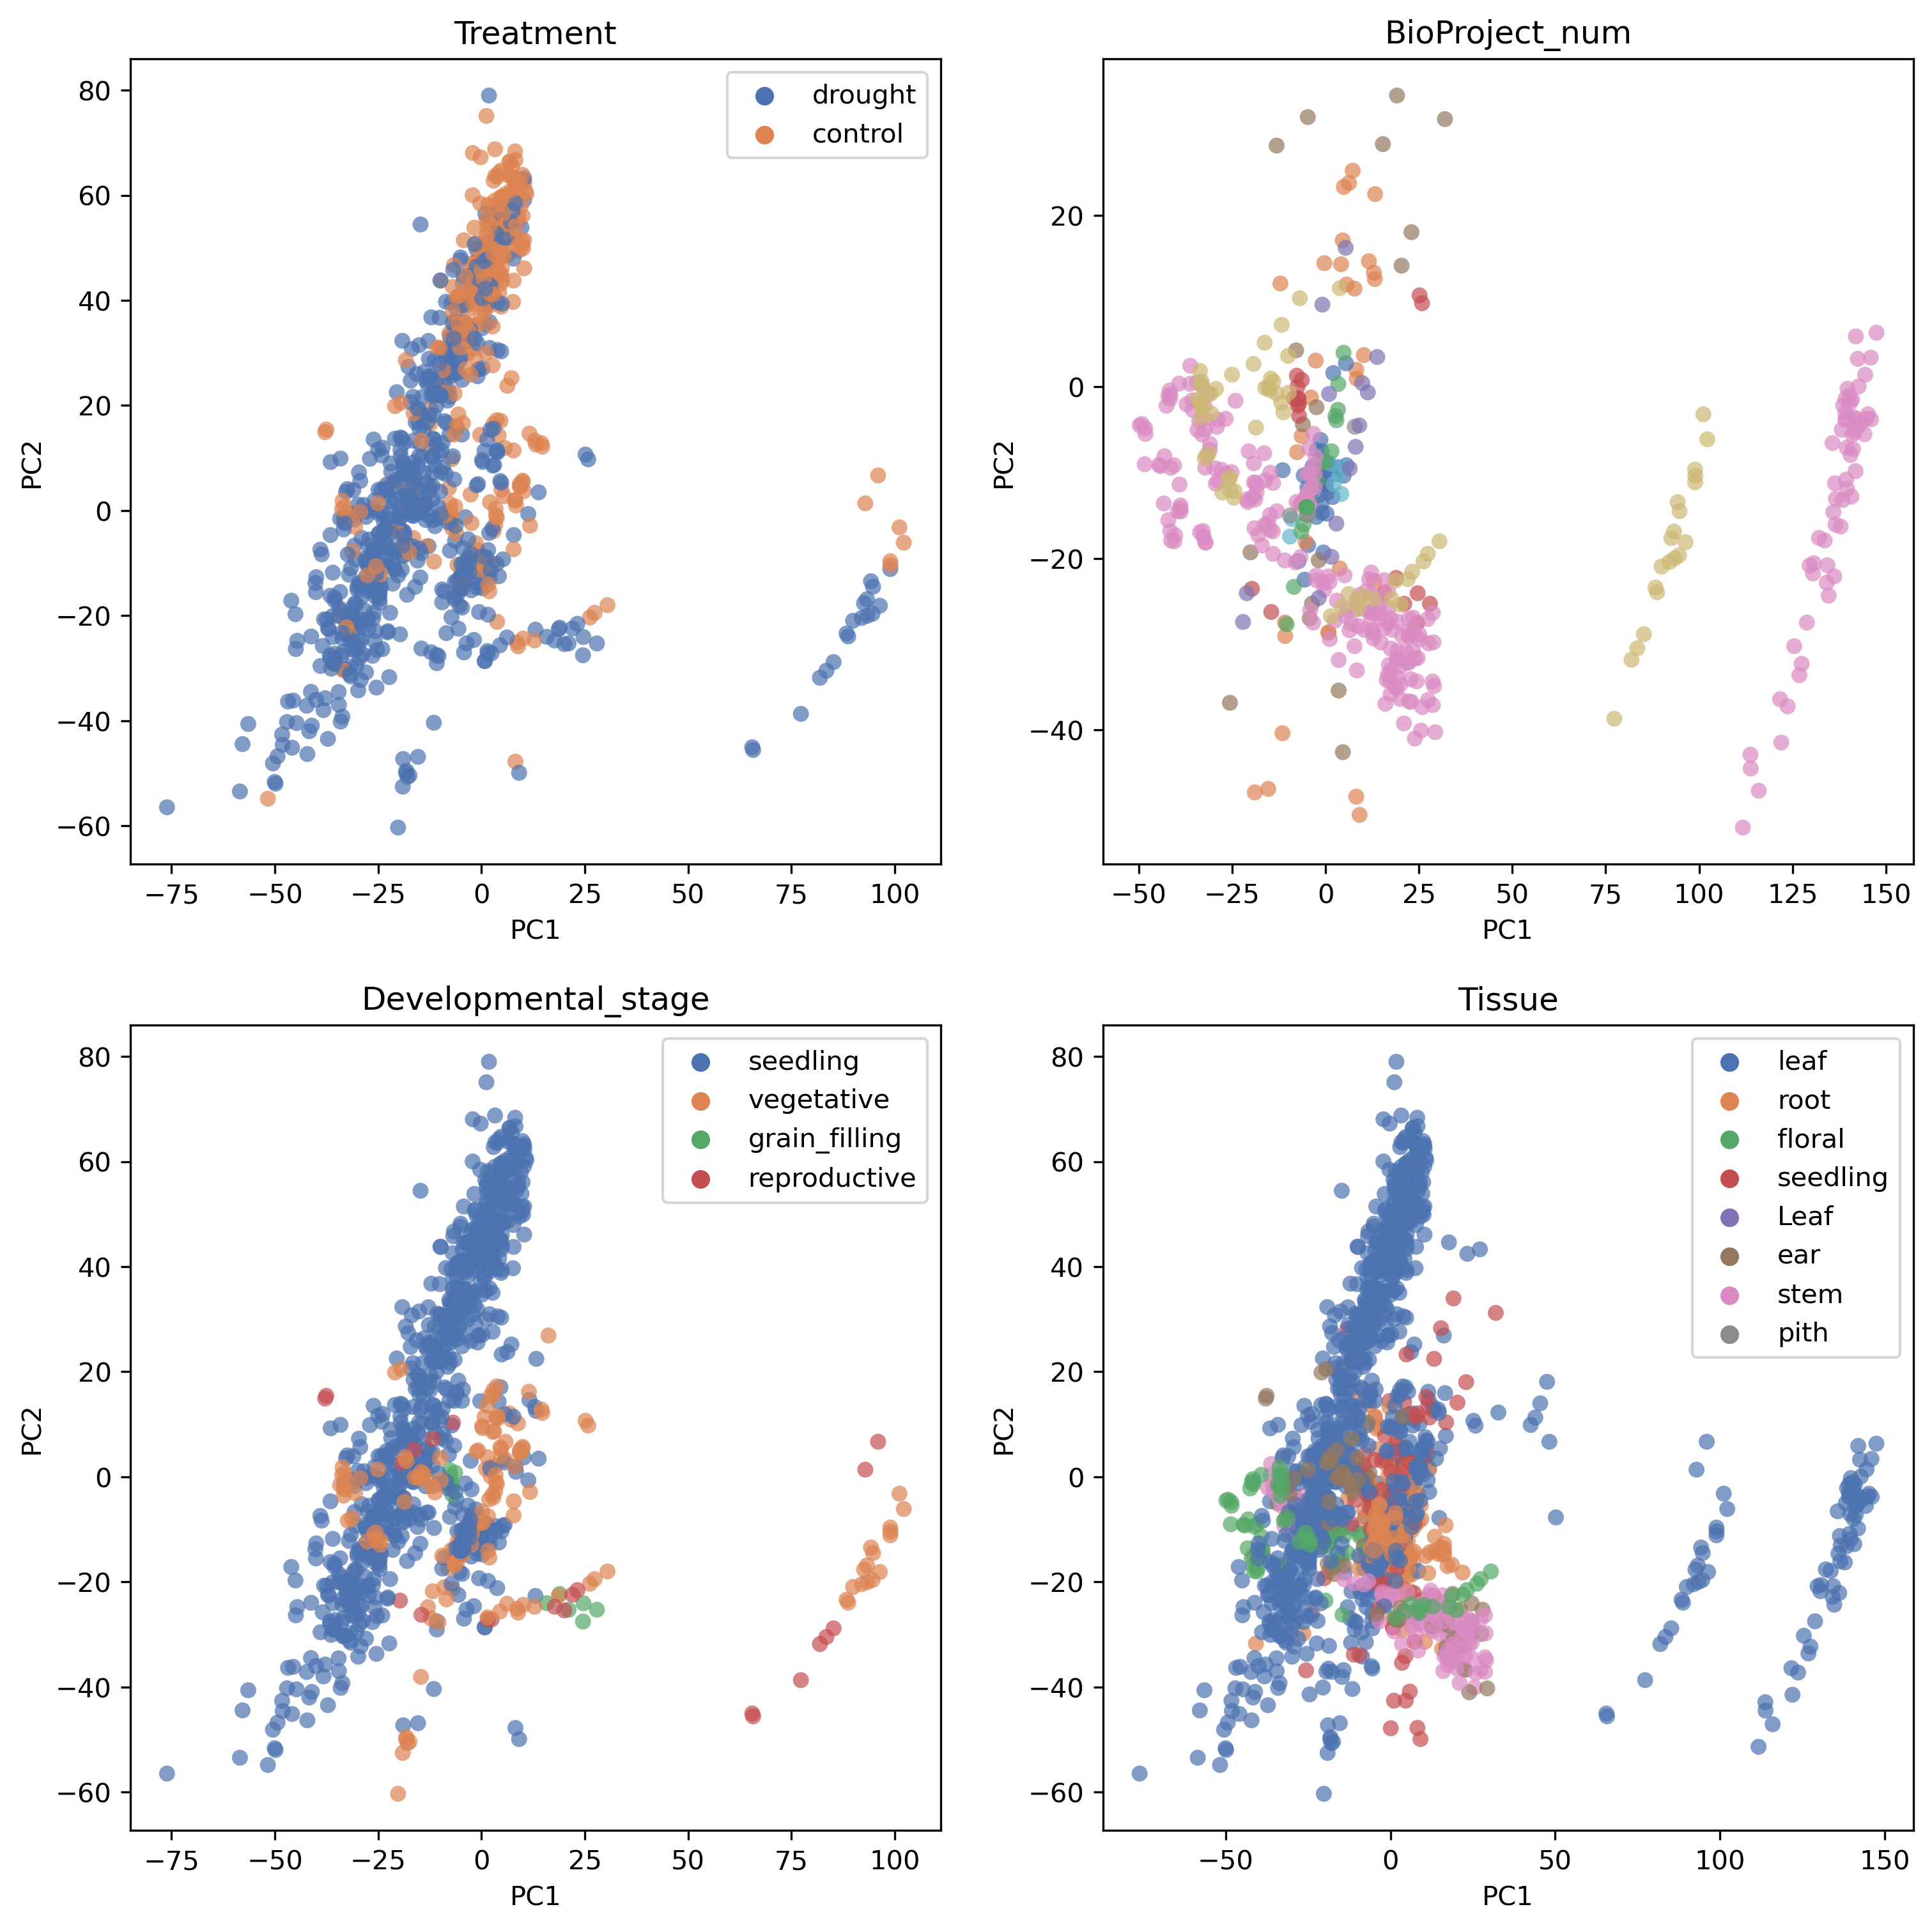

In [24]:
# Plot PCA by different factors

import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(12, 12), dpi=300)
axs = axs.flatten()
def scatter_plot(df, x, y, ax, labels=None, title="", palette='deep'):
    sns.scatterplot(x=x, y=y, data=df,
                    ax=ax,
                    alpha=0.7, # opacity of the points
                    linewidth=0, # outline of the data points
                    hue=labels,
                    palette=palette)
    ax.set_title(title)
    
labels = label_df['Treatment'] 
labels2 = label_df['BioProject_num'] 
labels3 = label_df['Developmental_stage'] 
labels4 = label_df['Tissue'] 

scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[0], labels, "Treatment")
scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[1], labels2, "BioProject_num")
scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[2], labels3, "Developmental_stage")
scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[3], labels4, "Tissue")

# Set legend visibility
axs[0].legend().set_visible(True)
axs[1].legend().set_visible(False)
axs[2].legend().set_visible(True)
axs[3].legend().set_visible(True)

plt.savefig('Maize_drought_PCA.pdf')

# Predictive modeling of drought stress genes

In [24]:
ML_labels = pd.read_csv('ML_labels.txt')
ML_labels.set_index('GeneID', inplace=True)
ML_labels.head()

,Treatment
GeneID,
ERR3212285,0
ERR3212286,0
ERR3212287,0
ERR3212288,0
ERR3212289,0


In [25]:
merged_df = log_expr_df_trans.merge(ML_labels, left_index=True, right_index=True)

In [26]:
merged_df.shape

(932, 36684)

In [27]:
expr_ML = expr_df_trans.merge(ML_labels, left_index=True, right_index=True)
expr_ML_clean = expr_ML.dropna()
expr_ML_clean.shape

(932, 36684)

In [28]:
expr_ML_clean.head()

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442830,Zm00001eb442870,Zm00001eb442880,Zm00001eb442890,Zm00001eb442940,Zm00001eb442960,Zm00001eb443030,Treatment
ERR3212273,8.076021,166.698450,0.133979,40.907926,0.096573,44.399551,0.891905,0.340876,2.963236,0.0,...,0.082009,8.878549,0.0,0.0,0.0,0.000000,0.150278,0.000000,0.000000,1
ERR3212274,9.048801,163.908864,0.000000,32.281766,0.000000,42.097516,0.891513,0.000000,0.198650,0.0,...,0.109476,9.237371,0.0,0.0,0.0,0.541685,0.000000,0.208349,0.000000,1
ERR3212275,7.110274,143.066893,0.264748,29.179100,0.000000,37.049221,0.557853,0.000000,0.467383,0.0,...,0.469516,10.015257,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
ERR3212276,7.324094,180.466531,0.000000,23.556925,0.000000,28.242949,0.415069,0.000000,1.257177,0.0,...,0.360945,7.365790,0.0,0.0,0.0,0.000000,0.109670,1.468700,2.148157,1
ERR3212277,8.005748,173.654064,0.000000,24.642888,0.000000,25.825212,0.416598,0.000000,0.580630,0.0,...,0.415707,8.046018,0.0,0.0,0.0,0.000000,0.000000,0.185291,0.000000,1


In [31]:
# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-1]  # Gene expression values
y = expr_ML_clean.iloc[:, -1].astype(int)    # Class labels

# Split the data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=5000, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8927038626609443
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83        75
           1       0.90      0.94      0.92       158

    accuracy                           0.89       233
   macro avg       0.89      0.86      0.87       233
weighted avg       0.89      0.89      0.89       233



In [32]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
# Choose the index of the tree you want to find the depth of (e.g., 0 for the first tree)
tree_index = 0

# Extract the decision tree from the random forest
tree: DecisionTreeClassifier = rf_classifier.estimators_[tree_index]

# Get the depth of the decision tree
tree_depth = tree.get_depth()

# Print the depth of the decision tree
print(f"Depth of Tree {tree_index}: {tree_depth}")

Depth of Tree 0: 16


In [33]:
cm = confusion_matrix(y_test, y_pred)
false_negatives = []

for i in range(len(y_test)):
    if y_test.iloc[i] == 1 and y_pred[i] == 0:
        false_negatives.append((X_test.iloc[i], y_test.index[i]))

false_negatives_df = pd.DataFrame([item[0] for item in false_negatives], index=[item[1] for item in false_negatives])
false_negatives_df

,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,Zm00001eb000150,...,Zm00001eb442800,Zm00001eb442810,Zm00001eb442820,Zm00001eb442830,Zm00001eb442870,Zm00001eb442880,Zm00001eb442890,Zm00001eb442940,Zm00001eb442960,Zm00001eb443030
SRR11933167,1.469155,0.000000,4.889055,2.527057,2.808152,0.000000,4.213745,0.000000,0.000000,0.000000,...,0.0,0.000000,1.160752,0.0,0.881858,0.0,13.188427,0.542827,0.000000,0.000000
SRR11932868,2.307627,0.442131,15.419280,1.520024,15.619374,0.293742,0.000000,0.129157,0.000000,0.000000,...,0.0,0.233533,1.160831,0.0,0.000000,0.0,0.000000,0.569830,0.000000,2.577008
SRR11933262,2.757943,0.644629,13.014674,11.429461,11.951617,1.824639,0.000000,1.534003,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.795257,0.0,0.000000,0.682032,0.000000,0.000000
SRR11933356,4.889419,0.067956,17.299527,3.243593,26.226357,0.000000,0.000000,1.758747,2.287110,0.000000,...,0.0,0.105773,0.000000,0.0,0.000000,0.0,0.000000,1.639081,0.000000,0.000000
SRR11933007,0.993963,0.079021,2.713028,7.971485,14.653875,0.000000,9.218763,0.890460,0.000000,0.000000,...,0.0,0.165328,0.020702,0.0,0.000000,0.0,36.747088,0.780099,0.000000,1.524173
SRR11933093,1.556046,0.138526,15.837664,10.116931,18.021779,0.514910,14.307177,0.426838,0.360134,0.000000,...,0.0,0.236986,0.000000,0.0,1.178241,0.0,0.801874,2.109038,0.177176,0.000000
SRR11932948,1.196054,0.000000,5.383740,2.273569,12.689225,0.000000,0.000000,0.404190,0.344196,1.569687,...,0.0,0.052328,0.000000,0.0,0.262317,0.0,0.000000,0.330132,0.000000,1.055384
SRR11932884,2.663446,0.000000,12.761298,23.410489,30.309709,0.000000,0.000000,0.876421,0.655095,0.000000,...,0.0,0.340090,0.015999,0.0,0.000000,0.0,0.000000,0.797902,0.000000,2.442057
SRR11933197,1.712712,0.096721,8.047134,0.000000,11.947960,0.000000,0.000000,0.310417,3.070085,0.000000,...,0.0,0.039234,0.000000,0.0,0.000000,0.0,0.309229,1.208657,0.000000,1.852147


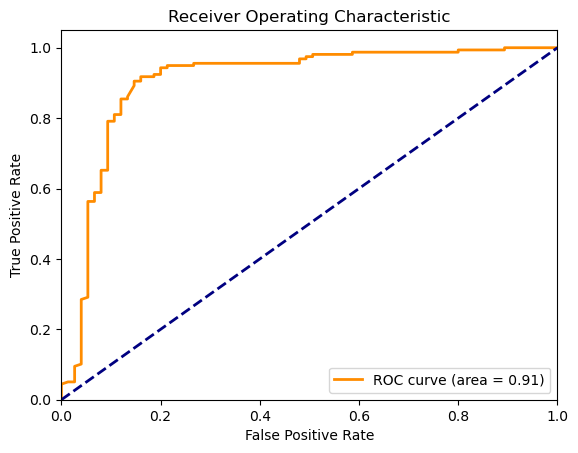

In [34]:
# Calculate the probabilities of the classes
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.pdf')
plt.show()

In [39]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a list of (feature, importance) tuples
feature_importance_list = list(zip(X.columns, feature_importances))

# Sort the list by importance in descending order
sorted_feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Print the feature importances
print("Feature Importances:")
for feature, importance in sorted_feature_importance_list:
    print(f"{feature}: {importance}")

Feature Importances:
Zm00001eb419870: 0.004933935062191124
Zm00001eb351790: 0.004087793008341544
Zm00001eb220700: 0.004078227010737225
Zm00001eb285360: 0.004032249971649845
Zm00001eb339080: 0.0039016180425559617
Zm00001eb012040: 0.0034852323445715475
Zm00001eb201180: 0.0031740232510531607
Zm00001eb155430: 0.002738692956251362
Zm00001eb248930: 0.0026885461291541396
Zm00001eb222250: 0.0026192329558718174
Zm00001eb249190: 0.0026070497823303543
Zm00001eb369590: 0.002571614652073088
Zm00001eb328100: 0.0025172598506767374
Zm00001eb112930: 0.002473080110722193
Zm00001eb050500: 0.0023676414373482216
Zm00001eb311680: 0.0022939722577151535
Zm00001eb160470: 0.0022454616615021844
Zm00001eb179190: 0.0022398266614403854
Zm00001eb281500: 0.002203133094833925
Zm00001eb409910: 0.0022023648235965153
Zm00001eb309920: 0.002168032823777647
Zm00001eb307340: 0.0021510735001042483
Zm00001eb192710: 0.00214904706434694
Zm00001eb124290: 0.002096204652624592
Zm00001eb392910: 0.00208633725064291
Zm00001eb367840: 0

Zm00001eb418150: 1.7512666946050095e-05
Zm00001eb244980: 1.7512487364710134e-05
Zm00001eb125900: 1.7509241945719208e-05
Zm00001eb318590: 1.7509108422251013e-05
Zm00001eb335680: 1.7508636046507573e-05
Zm00001eb268480: 1.7508630859320884e-05
Zm00001eb354450: 1.7508401596220917e-05
Zm00001eb216920: 1.7508358489618923e-05
Zm00001eb190610: 1.750341785655091e-05
Zm00001eb132970: 1.7500407690399752e-05
Zm00001eb061880: 1.7499565366210323e-05
Zm00001eb119450: 1.74992136245991e-05
Zm00001eb073840: 1.7497628698104453e-05
Zm00001eb094550: 1.7496237518882847e-05
Zm00001eb256040: 1.7493266867397474e-05
Zm00001eb261270: 1.7491987040840292e-05
Zm00001eb181070: 1.749194953406714e-05
Zm00001eb386740: 1.7490539219236557e-05
Zm00001eb244830: 1.749045920345911e-05
Zm00001eb100590: 1.7487481497201868e-05
Zm00001eb315530: 1.74872263346032e-05
Zm00001eb018610: 1.7484834917594246e-05
Zm00001eb060670: 1.7484286900974597e-05
Zm00001eb409440: 1.7481595258008152e-05
Zm00001eb353760: 1.748004138476994e-05
Zm00001e

Zm00001eb325110: 3.1380823578266863e-06
Zm00001eb147340: 3.137164539328151e-06
Zm00001eb263350: 3.136651090327953e-06
Zm00001eb241870: 3.1366332544188988e-06
Zm00001eb171550: 3.1364132946736126e-06
Zm00001eb324750: 3.1363613803207073e-06
Zm00001eb097870: 3.1352432209527487e-06
Zm00001eb200600: 3.1350195868506936e-06
Zm00001eb437180: 3.1344028869386634e-06
Zm00001eb157980: 3.134314444348163e-06
Zm00001eb264400: 3.1343094148922775e-06
Zm00001eb045800: 3.134195231416225e-06
Zm00001eb229740: 3.133216851326793e-06
Zm00001eb323050: 3.1319070564531137e-06
Zm00001eb351010: 3.1293349217289813e-06
Zm00001eb224860: 3.1270828919326633e-06
Zm00001eb248760: 3.125481034749657e-06
Zm00001eb271510: 3.1252250287783296e-06
Zm00001eb122000: 3.12411803795816e-06
Zm00001eb140070: 3.122405076958253e-06
Zm00001eb161310: 3.12187003529662e-06
Zm00001eb376720: 3.121302185325436e-06
Zm00001eb161360: 3.1212402057928177e-06
Zm00001eb077210: 3.1187439406836352e-06
Zm00001eb232090: 3.1178084982570675e-06
Zm00001eb188

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

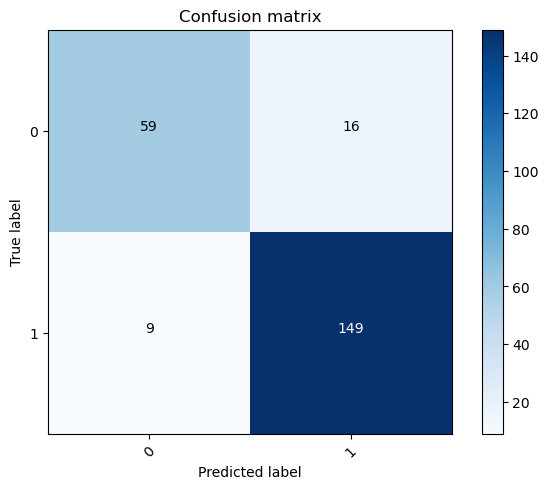

In [37]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define a custom function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=[0, 1])
plt.savefig('confusion_matrix.pdf')
plt.show()

In [38]:
from sklearn.neighbors import KNeighborsClassifier

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-1]  # Gene expression values
y = expr_ML_clean.iloc[:, -1].astype(int)    # Class labels

# Split the data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn_classifier.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7296137339055794
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.51      0.55        75
           1       0.78      0.84      0.81       158

    accuracy                           0.73       233
   macro avg       0.69      0.67      0.68       233
weighted avg       0.72      0.73      0.72       233



In [2]:
df = pd.read_csv('maize_TPM.tsv', sep='\t')
expr_df = df.set_index(df.columns[0])
expr_df.head()

,ERR3212267,ERR3212268,ERR3212269,ERR3212270,ERR3212271,ERR3212272,ERR3212273,ERR3212274,ERR3212275,ERR3212276,...,SRR342069,SRR342063,SRR342061,SRR2144431,SRR342060,SRR342064,SRR342071,SRR2144427,SRR2144433,SRR2144406
GeneID,,,,,,,,,,,,,,,,,,,,,
Zm00001eb000010,6.323837,5.873919,5.770463,6.352848,5.562371,4.732323,8.076021,9.048801,7.110274,7.324094,...,0,0,0,14.627677,0,0,0,5.315009,13.162300,4.535775
Zm00001eb000020,179.802513,165.847028,166.984711,152.416513,141.498510,140.814142,166.698450,163.908864,143.066893,180.466531,...,0,0,0,1.463291,0,0,0,149.387047,0.728733,0.733986
Zm00001eb000050,0.000000,0.000000,0.000000,0.058609,0.000000,0.000000,0.133979,0.000000,0.264748,0.000000,...,0,0,0,0.000000,0,0,0,0.513912,0.000000,0.000000
Zm00001eb000060,24.890536,23.165711,25.699378,23.120221,26.045797,24.001210,40.907926,32.281766,29.179100,23.556925,...,0,0,0,19.894300,0,0,0,39.035463,18.912029,8.224225
Zm00001eb000070,0.000000,0.068929,0.000000,0.000000,0.000000,0.000000,0.096573,0.000000,0.000000,0.000000,...,0,0,0,2.610392,0,0,0,2.698066,2.716753,0.487297


In [3]:
## Filter out non-expressed genes

expr_df = expr_df.loc[expr_df.sum(axis=1) > 10, :]
expr_df.shape

## Filter out lowly expressed genes

mask_low_vals = (expr_df > 1).sum(axis=1) > 10
expr_df = expr_df.loc[mask_low_vals, :]

### Filter out any SRA samples with all 0s

filtered_df = expr_df.loc[:, (expr_df != 0).any(axis=0)]

def log_transform(df):
    log_df = df.copy() # so we don't modify the original dataframe if we didn't want to
    
    # (Lifted from RNAseq_Meta_analysis.ipynb)
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] += 1
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] = np.log(log_df[c])
    return log_df

log_expr_df = log_transform(expr_df)

# Transpose of the data so each row corresponds to an SRA numbers
expr_df_trans = expr_df.transpose()
log_expr_df_trans = log_expr_df.transpose()

log_expr_df_trans.head()

GeneID,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442800,Zm00001eb442810,Zm00001eb442820,Zm00001eb442830,Zm00001eb442870,Zm00001eb442880,Zm00001eb442890,Zm00001eb442940,Zm00001eb442960,Zm00001eb443030
ERR3212267,1.991134,5.197405,0.000000,3.253877,0.000000,3.349387,0.373617,0.0,0.877204,0.0,...,0.0,0.175446,2.254614,0.0,0.0,0.0,0.0,0.000000,0.451179,0.000000
ERR3212268,1.927734,5.117077,0.000000,3.184935,0.066657,3.030443,0.362700,0.0,0.856867,0.0,...,0.0,0.379955,2.126438,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
ERR3212269,1.912569,5.123873,0.000000,3.284640,0.000000,3.158697,0.440691,0.0,1.204550,0.0,...,0.0,0.293646,2.171989,0.0,0.0,0.0,0.0,0.064186,0.998326,0.000000
ERR3212270,1.995088,5.033157,0.056956,3.183051,0.000000,3.140533,0.506764,0.0,0.687222,0.0,...,0.0,0.278296,2.226049,0.0,0.0,0.0,0.0,0.168403,0.639335,0.940857
ERR3212271,1.881352,4.959332,0.000000,3.297532,0.000000,3.024019,0.296170,0.0,0.484839,0.0,...,0.0,0.095196,2.192493,0.0,0.0,0.0,0.0,0.000000,0.897597,0.956923


In [8]:
ML_labels = pd.read_csv('Maize_ML_LOO.txt', delimiter='\t')
ML_labels.head()

,Run,Experiment_Type,Class_Label
0,ERR3212267,PRJEB31651,NaN
1,ERR3212268,PRJEB31651,NaN
2,ERR3212269,PRJEB31651,NaN
3,ERR3212270,PRJEB31651,NaN
4,ERR3212271,PRJEB31651,NaN


In [9]:
#log_expr_df_trans.set_index('GeneID', inplace=True)
ML_labels.set_index('Run', inplace=True)

merged_df = log_expr_df_trans.merge(ML_labels, left_index=True, right_index=True)

expr_ML = expr_df_trans.merge(ML_labels, left_index=True, right_index=True)
expr_ML_clean = expr_ML.dropna()
expr_ML_clean.shape

(887, 36685)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-2]  # Assuming the last two columns are 'Experiment_Type' and 'Class_Label'
y = expr_ML_clean.iloc[:, -1].astype(int)  # Class labels

# Get the unique experiment types from the 'Experiment_Type' column
unique_experiment_types = expr_ML_clean['Experiment_Type'].unique()

# Shuffle the experiment types randomly
import numpy as np
np.random.seed(42)  # For reproducibility
np.random.shuffle(unique_experiment_types)

# Calculate the index to split the experiment types into training and testing (80% - 20%)
split_idx = int(0.80 * len(unique_experiment_types))
train_experiment_types = unique_experiment_types[:split_idx]
test_experiment_types = unique_experiment_types[split_idx:]

# Filter the DataFrame to get training and testing data separately
train_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(train_experiment_types)]
test_data = expr_ML_clean[expr_ML_clean['Experiment_Type'].isin(test_experiment_types)]

# Separate features and target for training and testing data
X_train = train_data.iloc[:, 1:-2]
y_train = train_data.iloc[:, -1].astype(int)
X_test = test_data.iloc[:, 1:-2]
y_test = test_data.iloc[:, -1].astype(int)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=5000, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7363515312916112
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.85      0.68       253
           1       0.90      0.68      0.77       498

    accuracy                           0.74       751
   macro avg       0.74      0.76      0.73       751
weighted avg       0.79      0.74      0.74       751



In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-2]
y = expr_ML_clean.iloc[:, -1].astype(int)

# Assuming that the 'Experiment_Type' or some similar column indicates the experiment id
experiment_ids = expr_ML_clean['Experiment_Type'].unique()

scores = []
reports = []

# For each unique experiment id
for exp_id in experiment_ids:
    train_data = expr_ML_clean[expr_ML_clean['Experiment_Type'] != exp_id]
    test_data = expr_ML_clean[expr_ML_clean['Experiment_Type'] == exp_id]
    
    # Separate features and targets for training and testing data
    X_train = train_data.iloc[:, 1:-2]
    y_train = train_data.iloc[:, -1].astype(int)
    X_test = test_data.iloc[:, 1:-2]
    y_test = test_data.iloc[:, -1].astype(int)
    
    # Create and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Store the accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    
    scores.append(accuracy)
    reports.append(report)

    # Print individual experiment performance
    print(f"Experiment {exp_id}: Accuracy = {accuracy:.2f}")
    print(f"Classification Report for Experiment {exp_id}:")
    for label, metrics in report.items():
        if label != 'accuracy':
            print(f"  {label}: Precision = {metrics['precision']:.2f}, Recall = {metrics['recall']:.2f}, F1-score = {metrics['f1-score']:.2f}")
    print("-" * 50)
# Average accuracy and classification report
mean_accuracy = sum(scores) / len(scores)
print("Average Accuracy:", mean_accuracy)

# Averaging classification report might be more involved depending on what metrics you want
# For now, we'll just demonstrate averaging precision, recall, and f1-score for each class
avg_report = {label: {'precision': 0, 'recall': 0, 'f1-score': 0} for label in reports[0].keys() if label != 'accuracy'}
for report in reports:
    for label, metrics in report.items():
        if label != 'accuracy':
            avg_report[label]['precision'] += metrics['precision']
            avg_report[label]['recall'] += metrics['recall']
            avg_report[label]['f1-score'] += metrics['f1-score']

for label, metrics in avg_report.items():
    avg_report[label]['precision'] /= len(reports)
    avg_report[label]['recall'] /= len(reports)
    avg_report[label]['f1-score'] /= len(reports)

print("Average Classification Report:", avg_report)

Experiment PRJEB31651: Accuracy = 0.56
Classification Report for Experiment PRJEB31651:
  0: Precision = 0.54, Recall = 1.00, F1-score = 0.70
  1: Precision = 1.00, Recall = 0.08, F1-score = 0.15
  macro avg: Precision = 0.77, Recall = 0.54, F1-score = 0.43
  weighted avg: Precision = 0.76, Recall = 0.56, F1-score = 0.44
--------------------------------------------------
Experiment PRJEB50145: Accuracy = 0.67
Classification Report for Experiment PRJEB50145:
  0: Precision = 1.00, Recall = 0.33, F1-score = 0.50
  1: Precision = 0.60, Recall = 1.00, F1-score = 0.75
  macro avg: Precision = 0.80, Recall = 0.67, F1-score = 0.62
  weighted avg: Precision = 0.80, Recall = 0.67, F1-score = 0.62
--------------------------------------------------
Experiment PRJNA378714: Accuracy = 0.42
Classification Report for Experiment PRJNA378714:
  0: Precision = 1.00, Recall = 0.12, F1-score = 0.22
  1: Precision = 0.36, Recall = 1.00, F1-score = 0.53
  macro avg: Precision = 0.68, Recall = 0.56, F1-score

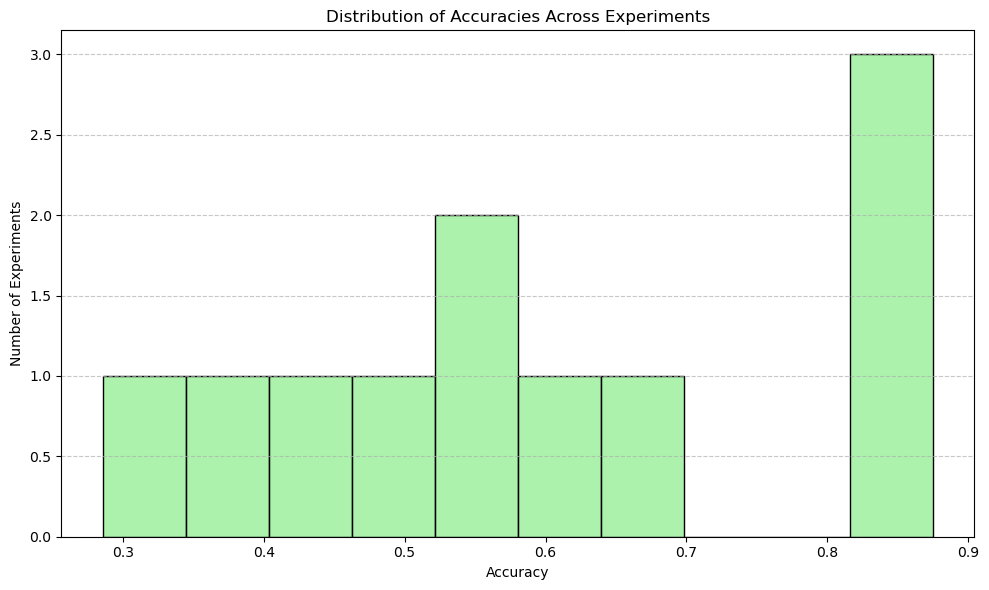

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=10, kde=False, color='lightgreen')  # You can adjust 'bins' as needed
plt.xlabel('Accuracy')
plt.ylabel('Number of Experiments')
plt.title('Distribution of Accuracies Across Experiments')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()